<a href="https://colab.research.google.com/github/BryanVqz/Python-Notes/blob/main/MCD_Treasury_Forecast_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Authentication Process**

In [5]:
# gets google credentials (you may receive a fishing alert email)
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

## **Data Extration from Google Sheets**


In [6]:
# from credentials provided, open the following worksheet
gc = gspread.authorize(creds)
wb = gc.open_by_key('1xqrkY338kED9Y558S6Jq97kS_xWuI1s9N-m-v2dWbJI')
ws = wb.worksheet('Treasury - Data')

# get_all_values gives a list of rows.
rows = ws.get_all_values()

# convert to a DataFrame and saved into df.
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df.head()


,Year,Month,Fiscal Week,Day,DOW,Date,Forecast,New Forecast,Actual,Delivery,New Delivery,Variance,New Variance,Accuracy,New Accuracy,Daily Notes,T
0,2021,January,Week 1,01,Friday,01/01/2021,903,,64,7.1%,,-92.9%,,7.1%,,2021 | *Payments may delay up to 3 days.,
1,2021,January,Week 1,02,Saturday,01/02/2021,746,,498,66.8%,,-33.2%,,66.8%,,,
2,2021,January,Week 1,03,Sunday,01/03/2021,473,,306,64.6%,,-35.4%,,64.6%,,,
3,2021,January,Week 2,04,Monday,01/04/2021,"1,732",,"1,378",79.6%,,-20.4%,,79.6%,,,
4,2021,January,Week 2,05,Tuesday,01/05/2021,"1,121",,"1,338",119.4%,,19.4%,,80.6%,,,


## **Actual Volume Data Preparation**

In [7]:
data = df[['Date', 'Actual']].copy(deep=True)

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(df['Date'])
data.set_index('Date', inplace=True)

# Apply lambda function to remove commas and convert to numeric
data['Actual'] = data['Actual'].apply(lambda x: int(x.replace(',', '')) if isinstance(x, str) and x.replace(',', '').isdigit() else None)

In [8]:
data

,Actual
Date,
2021-01-01,64.0
2021-01-02,498.0
2021-01-03,306.0
2021-01-04,1378.0
2021-01-05,1338.0
...,...
2024-12-27,NaN
2024-12-28,NaN
2024-12-29,NaN


In [9]:
# set year
#data = data[data.index.year == 2023]

# set data before yesterday
today = pd.Timestamp(datetime.now().date())
data = data[data.index < today]

data.dropna(inplace=True)
print('max date after dropping NaN rows:', data.index.max())
print(data['Actual'].head())

max date after dropping NaN rows: 2023-08-15 00:00:00
Date
2021-01-01      64.0
2021-01-02     498.0
2021-01-03     306.0
2021-01-04    1378.0
2021-01-05    1338.0
Name: Actual, dtype: float64


<ipython-input-9-ab28d8c39dff>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [10]:
# set data from the last x months
x_month_ago = pd.Timestamp(datetime.now().date()) - timedelta(days=12*30)  # Assuming an average of 30 days per month
data = data[data.index >= x_month_ago]

data.dropna(inplace=True)
print('max date after dropping NaN rows:', data.index.max())
print(data['Actual'].head(30))

max date after dropping NaN rows: 2023-08-15 00:00:00
Date
2022-08-21     81.0
2022-08-22    336.0
2022-08-23    187.0
2022-08-24    186.0
2022-08-25    202.0
2022-08-26    164.0
2022-08-27     70.0
2022-08-28     88.0
2022-08-29    264.0
2022-08-30    206.0
2022-08-31    254.0
2022-09-01    389.0
2022-09-02    310.0
2022-09-03    184.0
2022-09-04     85.0
2022-09-05    151.0
2022-09-06    819.0
2022-09-07    532.0
2022-09-08    303.0
2022-09-09    236.0
2022-09-10    161.0
2022-09-11    147.0
2022-09-12    320.0
2022-09-13    216.0
2022-09-14    200.0
2022-09-15    269.0
2022-09-16    203.0
2022-09-17    139.0
2022-09-18    108.0
2022-09-19    419.0
Name: Actual, dtype: float64


<ipython-input-10-47b23ffbbe11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


## **Actual Volume Visualization**

<Axes: xlabel='Date', ylabel='Actual'>

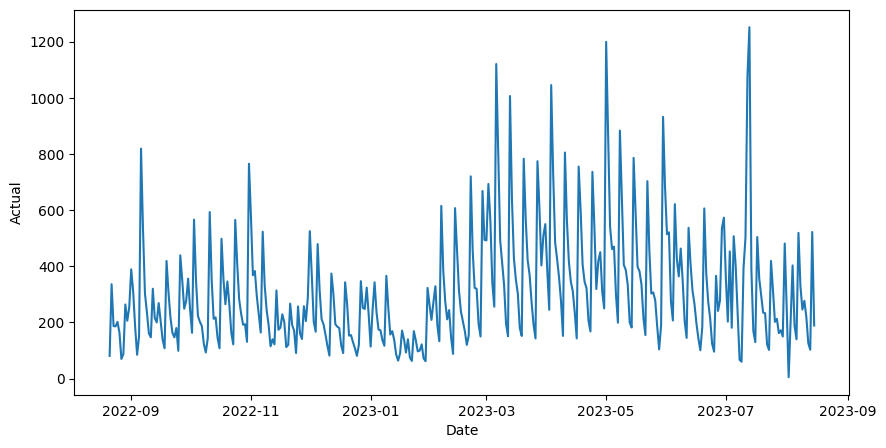

In [11]:
# set picture size
plt.figure(figsize=(10,5))
# see actual volume trend
sns.lineplot(data=data,x=data.index,y=data['Actual'])

In [12]:
window = 7
# creates two new columns, avg roll and std roll for last 7 days
data['rollMean'] = data['Actual'].rolling(window=window).mean()
data['rollStd'] = data['Actual'].rolling(window=window).std()

<Axes: xlabel='Date', ylabel='Actual'>

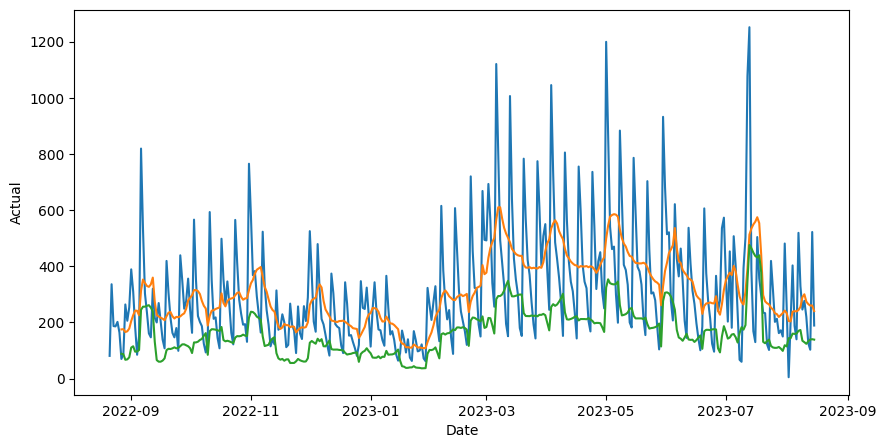

In [13]:
# set picture size
plt.figure(figsize=(10,5))

# plots Actuals vs rollMean vs rollStd
sns.lineplot(data=data, x=data.index, y=data['Actual'])
sns.lineplot(data=data, x=data.index, y=data['rollMean'])
sns.lineplot(data=data, x=data.index, y=data['rollStd'])

In [14]:
data

,Actual,rollMean,rollStd
Date,,,
2022-08-21,81.0,NaN,NaN
2022-08-22,336.0,NaN,NaN
2022-08-23,187.0,NaN,NaN
2022-08-24,186.0,NaN,NaN
2022-08-25,202.0,NaN,NaN
...,...,...,...
2023-08-11,220.0,274.142857,123.902419
2023-08-12,126.0,265.285714,132.970817
2023-08-13,103.0,260.000000,139.362836


# **Part 2: How to Check Stationarity**

## **ADF test** | *Augmented Dickey-Fuller*
`test statistics < critical values`

if true, data is **stationary**

In [15]:
def test_stationarity(dataframe, var):
  dataframe['rollMean'] = dataframe[var].rolling(window=window).mean()
  dataframe['rollStd'] = dataframe[var].rolling(window=window).std()

  from statsmodels.tsa.stattools import adfuller
  adf_test = adfuller(dataframe[var], autolag='AIC')
  stats = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#lags used','number of observations used'])
  print(stats)

  for key, values in adf_test[4].items():
    print('criticality',key,':',values)

  # set picture size
  plt.figure(figsize=(10,5))

  # plots Actuals vs rollMean vs rollStd
  sns.lineplot(data=data, x=data.index, y=data['Actual'])
  sns.lineplot(data=data, x=data.index, y=data['rollMean'])
  sns.lineplot(data=data, x=data.index, y=data['rollStd'])

  if adf_test[1] <= 0.05:
    print("It is Stationary data :D")
  else:
    print("It is non-Stationary data")


Test Statistic                  -2.566566
p-value                          0.100106
#lags used                      14.000000
number of observations used    345.000000
dtype: float64
criticality 1% : -3.4494474563375737
criticality 5% : -2.8699542285903887
criticality 10% : -2.5712527305187987
It is non-Stationary data


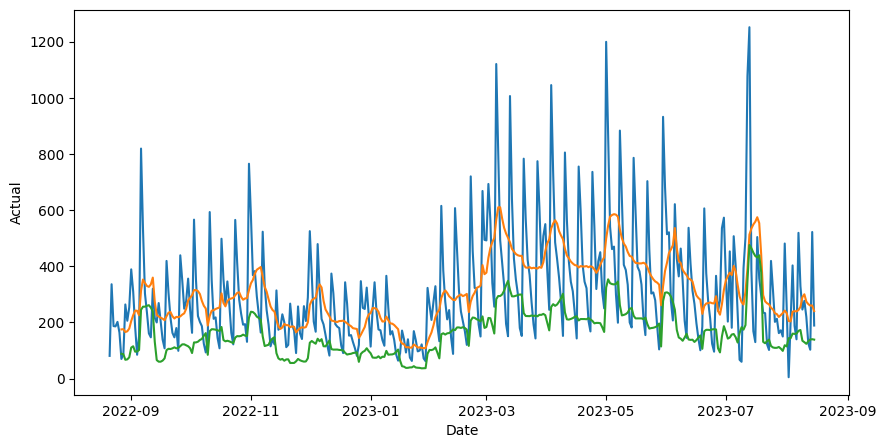

In [16]:
test_stationarity(data,'Actual')

In [17]:
data

,Actual,rollMean,rollStd
Date,,,
2022-08-21,81.0,NaN,NaN
2022-08-22,336.0,NaN,NaN
2022-08-23,187.0,NaN,NaN
2022-08-24,186.0,NaN,NaN
2022-08-25,202.0,NaN,NaN
...,...,...,...
2023-08-11,220.0,274.142857,123.902419
2023-08-12,126.0,265.285714,132.970817
2023-08-13,103.0,260.000000,139.362836


### **If is non-Stationary, it is time to transform our data into a Stationary data.**




            Actual  rollMean  rollStd  shiftDiff
Date                                            
2022-08-21    81.0       NaN      NaN        NaN
2022-08-22   336.0       NaN      NaN        NaN
2022-08-23   187.0       NaN      NaN        NaN
2022-08-24   186.0       NaN      NaN        NaN
2022-08-25   202.0       NaN      NaN        NaN
Test Statistic                -6.515893e+00
p-value                        1.071617e-08
#lags used                     1.500000e+01
number of observations used    3.370000e+02
dtype: float64
criticality 1% : -3.4499043309021955
criticality 5% : -2.870154885338925
criticality 10% : -2.5713597190254385
It is Stationary data :D


<ipython-input-15-5a8d4445c671>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rollMean'] = dataframe[var].rolling(window=window).mean()
<ipython-input-15-5a8d4445c671>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['rollStd'] = dataframe[var].rolling(window=window).std()


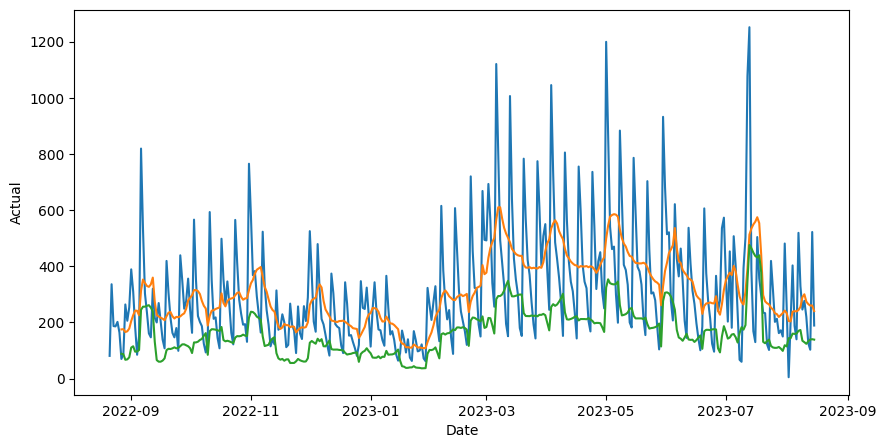

In [18]:
# differencing | time shift

data['shiftDiff'] = data['Actual'] - data['Actual'].shift(window)
print(data.head())

test_stationarity(data.dropna(),'shiftDiff')

In [ ]:
# log

data['log'] = np.log(data['Actual'])
print(data.tail())

test_stationarity(data,'log')

In [ ]:
# sqrt

data['sqrt'] = np.sqrt(data['Actual'])
print(data.tail())

test_stationarity(data,'sqrt')

In [ ]:
# cbrt

data['cbrt'] = np.cbrt(data['Actual'])
print(data.tail())

test_stationarity(data,'cbrt')

In [ ]:
# log sqrt

data['log_sqrt'] = np.sqrt(data['log'])
print(data.tail())

test_stationarity(data,'log_sqrt')

In [ ]:
# log shift

data['log_sqrt'] = np.sqrt(data['log'])
print(data.tail())

test_stationarity(data,'log_sqrt')

### **If is Stationary, continue to apply SARIMAX Model.**



In [39]:
data

,Actual,rollMean,rollStd,shiftDiff
Date,,,,
2022-08-21,81.0,NaN,NaN,NaN
2022-08-22,336.0,NaN,NaN,NaN
2022-08-23,187.0,NaN,NaN,NaN
2022-08-24,186.0,NaN,NaN,NaN
2022-08-25,202.0,NaN,NaN,NaN
...,...,...,...,...
2023-08-11,220.0,274.142857,123.902419,-183.0
2023-08-12,126.0,265.285714,132.970817,-62.0
2023-08-13,103.0,260.000000,139.362836,-37.0


In [40]:
data_fcst = data.loc[:, ['Actual', 'shiftDiff']].copy(deep=True)

In [41]:
data_fcst

,Actual,shiftDiff
Date,,
2022-08-21,81.0,NaN
2022-08-22,336.0,NaN
2022-08-23,187.0,NaN
2022-08-24,186.0,NaN
2022-08-25,202.0,NaN
...,...,...
2023-08-11,220.0,-183.0
2023-08-12,126.0,-62.0
2023-08-13,103.0,-37.0


In [42]:
train = data_fcst[:round(len(data_fcst) * 100 / 100)]
print("Train set:")
print(train.head())
print(train.tail())

test = data_fcst[round(len(data_fcst) * 5 / 100):]
print("\nTest set:")
print(test.head())
print(test.tail())

Train set:
            Actual  shiftDiff
Date                         
2022-08-21    81.0        NaN
2022-08-22   336.0        NaN
2022-08-23   187.0        NaN
2022-08-24   186.0        NaN
2022-08-25   202.0        NaN
            Actual  shiftDiff
Date                         
2023-08-11   220.0     -183.0
2023-08-12   126.0      -62.0
2023-08-13   103.0      -37.0
2023-08-14   522.0        3.0
2023-08-15   189.0     -140.0

Test set:
            Actual  shiftDiff
Date                         
2022-09-08   303.0      -86.0
2022-09-09   236.0      -74.0
2022-09-10   161.0      -23.0
2022-09-11   147.0       62.0
2022-09-12   320.0      169.0
            Actual  shiftDiff
Date                         
2023-08-11   220.0     -183.0
2023-08-12   126.0      -62.0
2023-08-13   103.0      -37.0
2023-08-14   522.0        3.0
2023-08-15   189.0     -140.0


# **AR Model**

<Figure size 1000x500 with 0 Axes>

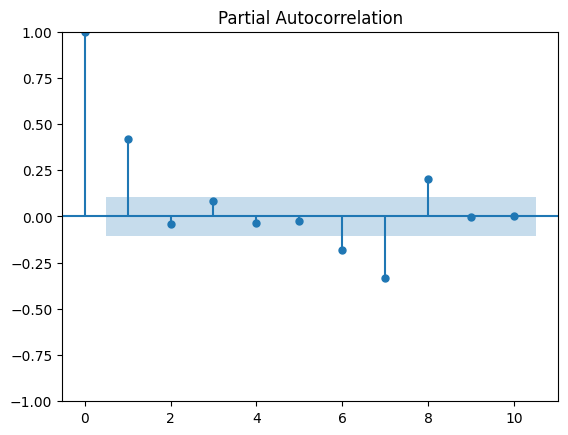

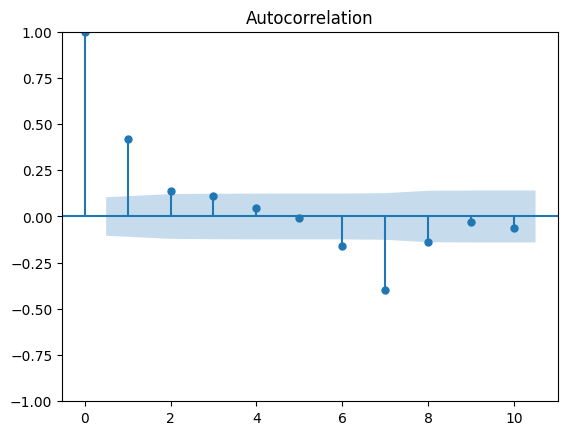

In [43]:
plt.figure(figsize=(10,5))
plot_pacf(data_fcst['shiftDiff'].dropna(), lags=10);
plot_acf(data_fcst['shiftDiff'].dropna(), lags=10);

# **ARIMA Model**
*p,d,q*
*  p - AR model
*  d - differencing
*  q - MA lags




In [ ]:
# p - 0, 1
# d - 7 (number of seasons)
# q - 0, 1 ,2

p, d, q = 1 , 0 , 3

In [766]:
model = ARIMA(train['Actual'],order=(p,d,q))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
data_fcst['arimaPred'] = prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [764]:
data_fcst.dropna()

,Actual,Forecast
2023-08-01,252.0,430.691331
2023-08-02,5.0,314.137392
2023-08-03,204.0,281.489619
2023-08-04,403.0,271.546691
2023-08-05,188.0,159.780786
2023-08-06,140.0,113.146932
2023-08-07,519.0,407.637304
2023-08-08,329.0,416.360557
2023-08-09,246.0,303.686076
2023-08-10,277.0,272.124530


ValueError: ignored

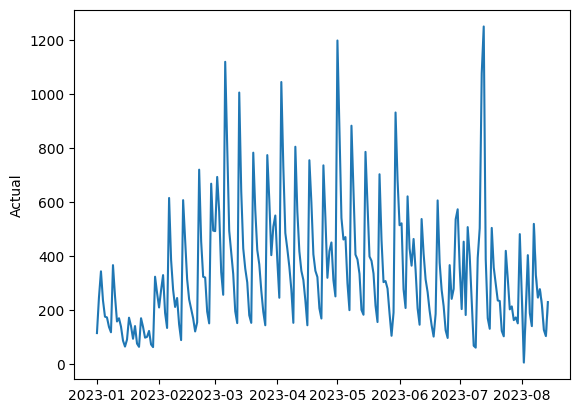

In [765]:
sns.lineplot(data=data_fcst, x=data_fcst.index, y='Actual')
sns.lineplot(data=data_fcst, x=data_fcst.index, y='arimaPred')

error = np.sqrt(mean_squared_error(test['Actual'], prediction))
print("error: ", error)

# ***SARIMAX Model***

In [72]:
print("\nTrain dates :")
print(train.head())
print("\n\nTest dates:")
print(test.head())
print(test.tail())


Train dates :
            Actual  shiftDiff
Date                         
2022-08-21    81.0        NaN
2022-08-22   336.0        NaN
2022-08-23   187.0        NaN
2022-08-24   186.0        NaN
2022-08-25   202.0        NaN


Test dates:
            Actual  shiftDiff
Date                         
2022-09-08   303.0      -86.0
2022-09-09   236.0      -74.0
2022-09-10   161.0      -23.0
2022-09-11   147.0       62.0
2022-09-12   320.0      169.0
            Actual  shiftDiff
Date                         
2023-08-11   220.0     -183.0
2023-08-12   126.0      -62.0
2023-08-13   103.0      -37.0
2023-08-14   522.0        3.0
2023-08-15   189.0     -140.0


## **Best ARIMAX Variables**

In [25]:
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

p_values = range(0, 3)  # Example range for p
d_values = range(0, 2)  # Example range for d
q_values = range(0, 3)  # Example range for q

parameter_combinations = list(itertools.product(p_values, d_values, q_values))

best_e = np.inf  # Initialize best_e to a high value
best_params = None

y = train['Actual'].copy()

for params in parameter_combinations:
    model = SARIMAX(y, order=params, seasonal_order=(params + (window,)))
    model_fit = model.fit()
    prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
    error = np.sqrt(mean_squared_error(test['Actual'], prediction))
    if error < best_e:
        best_e = error
        best_params = params


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [45]:
best_e, best_params

(129.5337541713951, (2, 0, 2))

## **Train  ARIMAX Model**

In [46]:
p, d, q = best_params

model = SARIMAX(train['Actual'],order=(p,d,q), seasonal_order=(p,d,q, window))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
data_fcst['Forecast'] = prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [73]:
data_fcst

,Actual,Forecast
2022-08-21,81.0,NaN
2022-08-22,336.0,NaN
2022-08-23,187.0,NaN
2022-08-24,186.0,NaN
2022-08-25,202.0,NaN
...,...,...
2023-09-27,NaN,NaN
2023-09-28,NaN,NaN
2023-09-29,NaN,NaN
2023-09-30,NaN,NaN


error:  129.5337541713951


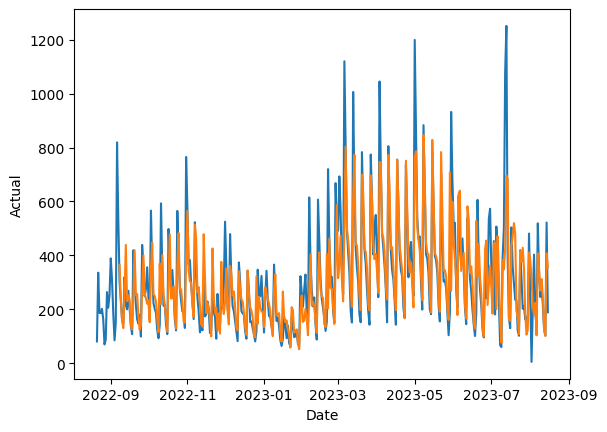

In [48]:
data_fcst.dropna()

sns.lineplot(data=data_fcst, x=data_fcst.index, y='Actual')
sns.lineplot(data=data_fcst, x=data_fcst.index, y='Forecast')

error = np.sqrt(mean_squared_error(test['Actual'], prediction))
print("error: ", error)

# **Prediction with ARIMAX Model**

In [74]:
# creates forecast range creation
start_range = '2023-05-29'
end_range = '2023-10-01'

date_range = pd.date_range(start=start_range, end=end_range)
date_range = pd.DataFrame(date_range, columns=['Dates'])
date_range.set_index('Dates', inplace=True )

data_fcst = pd.concat([data_fcst, date_range], ignore_index=False)
data_fcst

,Actual,Forecast
2022-08-21,81.0,NaN
2022-08-22,336.0,NaN
2022-08-23,187.0,NaN
2022-08-24,186.0,NaN
2022-08-25,202.0,NaN
...,...,...
2023-09-27,NaN,NaN
2023-09-28,NaN,NaN
2023-09-29,NaN,NaN
2023-09-30,NaN,NaN


In [75]:
prediction = model_fit.predict(start=date_range.index[0], end=date_range.index[-1])

data_fcst['Forecast'] = prediction

In [76]:
data_fcst = data_fcst.loc[:, ['Actual', 'Forecast']].copy(deep=True)


In [77]:
data_fcst

,Actual,Forecast
2022-08-21,81.0,NaN
2022-08-22,336.0,NaN
2022-08-23,187.0,NaN
2022-08-24,186.0,NaN
2022-08-25,202.0,NaN
...,...,...
2023-09-27,NaN,188.498741
2023-09-28,NaN,237.441368
2023-09-29,NaN,188.481427
2023-09-30,NaN,96.746799


# **Data Export**

In [78]:
# Set up credentials
gc = gspread.authorize(creds)

# Open the existing Google Sheets document
wb = gc.open_by_key('1xqrkY338kED9Y558S6Jq97kS_xWuI1s9N-m-v2dWbJI')  # Replace with your document key
ws = wb.worksheet('Treasury - Daily')  # Replace with your worksheet name

In [79]:
data_export = data_fcst.reset_index()
data_export = data_export.rename(columns={'index': 'Date'})
data_export = data_export.drop(columns=['Actual'])

In [80]:
data_export

,Date,Forecast
0,2022-08-21,NaN
1,2022-08-22,NaN
2,2022-08-23,NaN
3,2022-08-24,NaN
4,2022-08-25,NaN
...,...,...
670,2023-09-27,188.498741
671,2023-09-28,237.441368
672,2023-09-29,188.481427
673,2023-09-30,96.746799


In [105]:
# Add header and dataframe values
header = data_export.columns.tolist()
values = data_export.values.tolist()

# Write the header to cell A1
ws.update('A1', [header])

print("Header exported to Google Sheets successfully.")

Header exported to Google Sheets successfully.


## **Data Validation**

In [82]:
print(header)
print(len(header))

['Date', 'Forecast']
2


In [83]:
print(values)
print(len(values))

[[Timestamp('2022-08-21 00:00:00'), nan], [Timestamp('2022-08-22 00:00:00'), nan], [Timestamp('2022-08-23 00:00:00'), nan], [Timestamp('2022-08-24 00:00:00'), nan], [Timestamp('2022-08-25 00:00:00'), nan], [Timestamp('2022-08-26 00:00:00'), nan], [Timestamp('2022-08-27 00:00:00'), nan], [Timestamp('2022-08-28 00:00:00'), nan], [Timestamp('2022-08-29 00:00:00'), nan], [Timestamp('2022-08-30 00:00:00'), nan], [Timestamp('2022-08-31 00:00:00'), nan], [Timestamp('2022-09-01 00:00:00'), nan], [Timestamp('2022-09-02 00:00:00'), nan], [Timestamp('2022-09-03 00:00:00'), nan], [Timestamp('2022-09-04 00:00:00'), nan], [Timestamp('2022-09-05 00:00:00'), nan], [Timestamp('2022-09-06 00:00:00'), nan], [Timestamp('2022-09-07 00:00:00'), nan], [Timestamp('2022-09-08 00:00:00'), nan], [Timestamp('2022-09-09 00:00:00'), nan], [Timestamp('2022-09-10 00:00:00'), nan], [Timestamp('2022-09-11 00:00:00'), nan], [Timestamp('2022-09-12 00:00:00'), nan], [Timestamp('2022-09-13 00:00:00'), nan], [Timestamp('202

In [84]:
# vector = []

#for i, row in enumerate(values):
#  for j, value in enumerate(row):
#    vector.append(value)

#list comprehension
vector = [value for row in values for value in row]

print(vector[:2])

[Timestamp('2022-08-21 00:00:00'), nan]


In [85]:
for i, row in enumerate(values[-5:], start=len(values) - 4):
    print(f"Row {i}:")
    print("\n".join([f"  Column {j }: {value}" for j, value in enumerate(row)])) # list comprehension - j(column) value(cell value)

Row 671:
  Column 0: 2023-09-27 00:00:00
  Column 1: 188.49874130954686
Row 672:
  Column 0: 2023-09-28 00:00:00
  Column 1: 237.44136841002558
Row 673:
  Column 0: 2023-09-29 00:00:00
  Column 1: 188.4814267874935
Row 674:
  Column 0: 2023-09-30 00:00:00
  Column 1: 96.74679908728302
Row 675:
  Column 0: 2023-10-01 00:00:00
  Column 1: 70.03727023055171


## **Google Sheets Export Process**

In [86]:
# Filter the existing DataFrame
filtered_data = data_export[(start_range <= pd.to_datetime(data_export['Date'])) & (pd.to_datetime(data_export['Date']) <= end_range)]
# Drop duplicates from the filtered data
filtered_data = filtered_data.drop_duplicates()
# Convert filtered data to a list of lists
filtered_data_list = filtered_data.values.tolist()

In [91]:
# Print the last item in the filtered data list
print(filtered_data_list[0])
print(filtered_data_list[-1])

[Timestamp('2023-05-29 00:00:00'), 708.3168389008472]
[Timestamp('2023-10-01 00:00:00'), 70.03727023055171]


In [109]:
# Find the last row with information in column A
column_a = ws.col_values(1)
if '' in column_a:
    last_row = len(column_a) - column_a[::-1].index('') - 1
else:
    last_row = len(column_a)

last_row

127

In [108]:
from tqdm import tqdm  # Import the tqdm library

# Create a progress bar
progress_bar = tqdm(total=len(filtered_data_list)-1, desc="Updating Cells", unit="cell")

# Iterate through the values and update cells
for i in range(len(filtered_data_list)):
  cell_range = 'A' + str(i + last_row + 1)
  date_str = filtered_data_list[i][0].strftime('%m/%d/%Y')  # Convert date to string with 'yyyy-mm-dd' format

  #date_str = date_str[1:]  # Remove the first character
  value = str(filtered_data_list[i][1])  # Convert the value to a string

  value_to_update = [date_str, round(filtered_data_list[i][1], 2)]

  # Update the cell with the new rounded value
  ws.update(cell_range, [value_to_update])

  # Update the progress bar
  progress_bar.update()

# Close the progress bar
progress_bar.close()

print("\nCell updates completed successfully.")



Updating Cells:   6%|▋         | 8/125 [00:25<06:12,  3.18s/cell]

Updating Cells: 100%|██████████| 125/125 [00:55<00:00,  2.21cell/s]
Updating Cells: 126cell [00:56,  2.25cell/s]


Cell updates completed successfully.


# **Reprocess Daily Data**

# **7-Day locked Forecast**

# **21-Day locked Forecast**